Setup

In [84]:
%pip install -r requirements.txt

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

Note: you may need to restart the kernel to use updated packages.


GRAPH REPRESENTATION

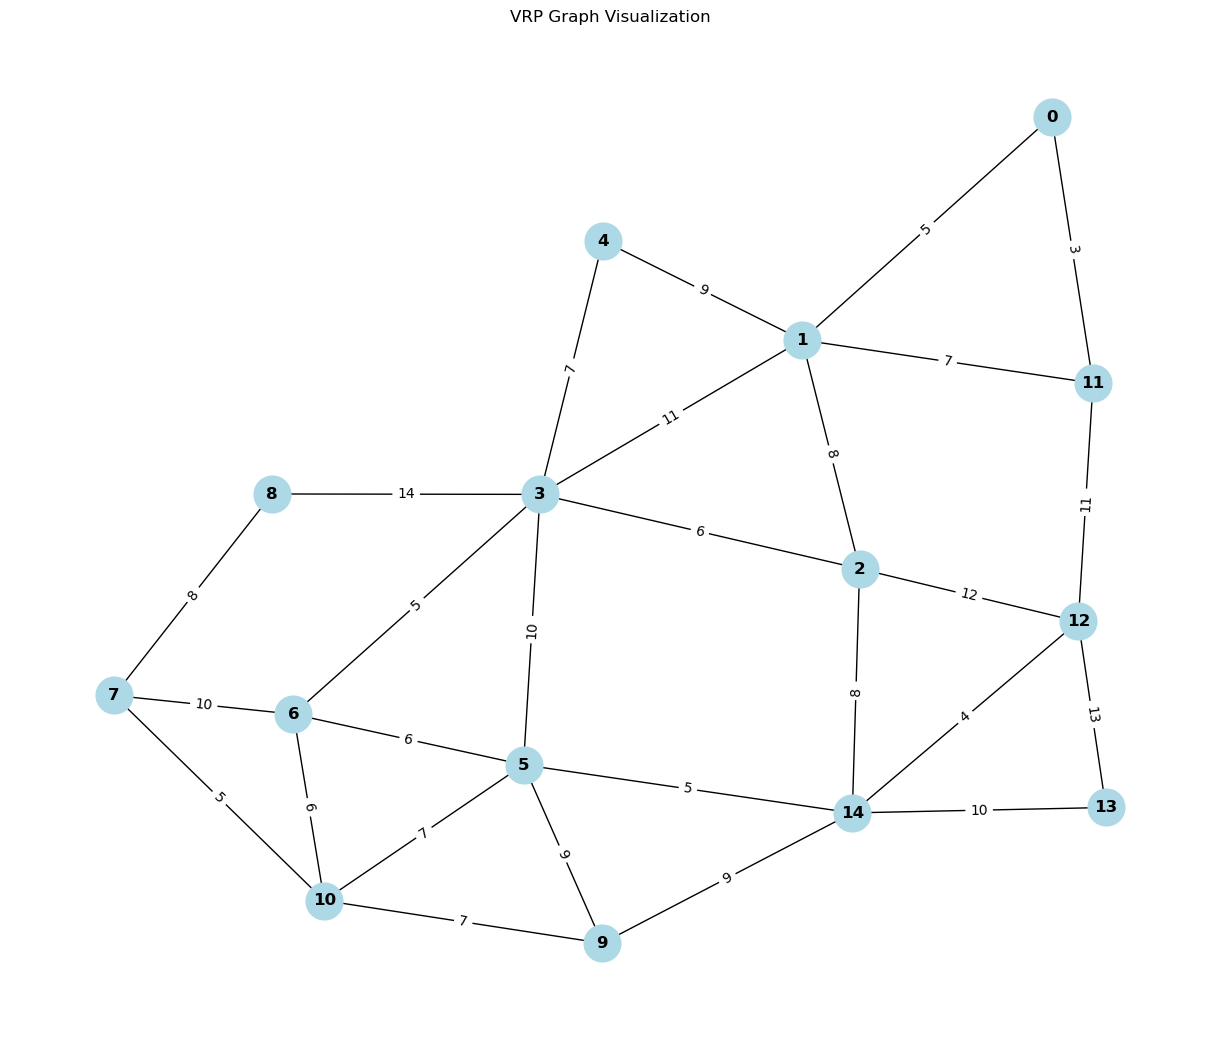

In [85]:
POPULATION_SIZE = 1000
ELITE_COUNT = 10
MAX_GENERATION = 1000
TOURNAMENT_SIZE = 5

TOTAL_CUSTOMER = 15
VEHICLE_CAPACITY = 30
MUTATION_RATE = 0.2

edge_list = [
    (0, 1, 5), (0, 11, 3),
    (1, 2, 8), (1, 3, 11), (1, 4, 9), (1, 11, 7),
    (2, 3, 6), (2, 12, 12), (2, 14, 8),
    (3, 4, 7), (3, 5, 10), (3, 6, 5), (3, 8, 14),
    (5, 6, 6), (5, 9, 9), (5, 10, 7), (5, 14, 5),
    (6, 7, 10), (6, 10, 6),
    (7, 8, 8), (7, 10, 5),
    (9, 10, 7), (9, 14, 9),
    (11, 12, 11),
    (12, 13, 13), (12, 14, 4),
    (13, 14, 10)
]

customer_demand = [0, 2, 10, 5, 14, 3, 8, 20, 4, 6, 1, 13, 8, 16, 3]

G = nx.Graph()
G.add_nodes_from(range(TOTAL_CUSTOMER))
G.add_weighted_edges_from(edge_list)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='lightblue',
    font_weight='bold',
    node_size=700
)

edge_labels = nx.get_edge_attributes(G, 'weight')

nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=edge_labels
)

plt.title("VRP Graph Visualization")
plt.show()


DISTANCE MATRIX

In [86]:

dist_matrix_fw = nx.floyd_warshall_numpy(G, weight='weight')

dist_matrix_dj = np.zeros((TOTAL_CUSTOMER, TOTAL_CUSTOMER))
for i in range(TOTAL_CUSTOMER):
    for j in range(TOTAL_CUSTOMER):
        if i == j:
            dist_matrix_dj[i][j] = 0
        else:
            dist_matrix_dj[i][j] = nx.shortest_path_length(G, i, j, weight='weight')

print(dist_matrix_fw)
print("*" * 100)
print(dist_matrix_dj)

[[ 0.  5. 13. 16. 14. 23. 21. 31. 30. 27. 27.  3. 14. 27. 18.]
 [ 5.  0.  8. 11.  9. 21. 16. 26. 25. 25. 22.  7. 18. 26. 16.]
 [13.  8.  0.  6. 13. 13. 11. 21. 20. 17. 17. 15. 12. 18.  8.]
 [16. 11.  6.  0.  7. 10.  5. 15. 14. 18. 11. 18. 18. 24. 14.]
 [14.  9. 13.  7.  0. 17. 12. 22. 21. 25. 18. 16. 25. 31. 21.]
 [23. 21. 13. 10. 17.  0.  6. 12. 20.  9.  7. 20.  9. 15.  5.]
 [21. 16. 11.  5. 12.  6.  0. 10. 18. 13.  6. 23. 15. 21. 11.]
 [31. 26. 21. 15. 22. 12. 10.  0.  8. 12.  5. 32. 21. 27. 17.]
 [30. 25. 20. 14. 21. 20. 18.  8.  0. 20. 13. 32. 29. 35. 25.]
 [27. 25. 17. 18. 25.  9. 13. 12. 20.  0.  7. 24. 13. 19.  9.]
 [27. 22. 17. 11. 18.  7.  6.  5. 13.  7.  0. 27. 16. 22. 12.]
 [ 3.  7. 15. 18. 16. 20. 23. 32. 32. 24. 27.  0. 11. 24. 15.]
 [14. 18. 12. 18. 25.  9. 15. 21. 29. 13. 16. 11.  0. 13.  4.]
 [27. 26. 18. 24. 31. 15. 21. 27. 35. 19. 22. 24. 13.  0. 10.]
 [18. 16.  8. 14. 21.  5. 11. 17. 25.  9. 12. 15.  4. 10.  0.]]
******************************************************

GA HELPER FUNCTION

In [87]:
def generate_chrom():
    chrom = list(range(1, TOTAL_CUSTOMER))
    random.shuffle(chrom)
    return chrom


def generate_population(total_population: int):
    pop = []
    for i in range(total_population):
        pop.append(generate_chrom())
    return pop


def decode_chrom(chrom: list):
    routes = []
    current_route = [0]
    current_load = 0
    chrom_copy = chrom.copy()

    while len(chrom_copy):
        current_load += customer_demand[chrom_copy[0]]
        if current_load <= VEHICLE_CAPACITY:
            current_route.append(chrom_copy.pop(0))
        else:
            current_load -= customer_demand[chrom_copy[0]]
            current_route.append(0)
            routes.append(current_route)
            current_route = [0]
            current_load = 0
        
    current_route.append(0)
    routes.append(current_route)

    total_dist = 0
    for route in routes:
        for a, b in zip(route, route[1:]):
            total_dist += dist_matrix_fw[a][b]

    return routes, total_dist


def calculate_fitness(chrom: list):
    routes, total_dist = decode_chrom(chrom)
    if len(routes) > 4:
        return 0
    if total_dist == 0:
        return 0
    return 1 / total_dist


def tournament_selection(population, tournament_size=TOURNAMENT_SIZE):
    contestant = random.sample(population, tournament_size)
    winner = max(contestant, key=calculate_fitness)
    return winner


def get_elite(population, elite_count=ELITE_COUNT):
    population_with_fitness_value = []

    for i in range(len(population)):
        fitness_value = calculate_fitness(population[i])
        population_with_fitness_value.append((population[i], fitness_value))
        
    population_with_fitness_value.sort(key=lambda x: x[1], reverse=True)
    return [chrom for chrom, fitness in population_with_fitness_value[:elite_count]]

def _build_aex_lookup(chrom: list):
    lookup_map = {}

    for i in range(TOTAL_CUSTOMER-1):
        current_customer = chrom[i]

        if i == TOTAL_CUSTOMER - 2:
            next_customer = chrom[0]
        else:
            next_customer = chrom[i+1]
        
        lookup_map[current_customer] = next_customer
    
    return lookup_map


def aex_crossover(parent_1: list, parent_2: list):
    p1_map = _build_aex_lookup(parent_1)
    p2_map = _build_aex_lookup(parent_2)

    child = [None] * (TOTAL_CUSTOMER-1)
    visited = set()

    current_customer = parent_1[0]

    child[0] = current_customer
    visited.add(current_customer)

    current_parent_map = p2_map

    for i in range(1, TOTAL_CUSTOMER-1):
        next_customer = current_parent_map[current_customer]

        if next_customer in visited:
            all_nodes = set(parent_1)
            unvisited_customer = list(all_nodes - visited)

            if not unvisited_customer:
                break

            next_customer = random.choice(unvisited_customer)

        child[i] = next_customer
        visited.add(next_customer)
        current_customer = next_customer

        if current_parent_map == p1_map:
            current_parent_map = p2_map
        else:
            current_parent_map = p1_map

    return child


def inverse_mutation(chrom: list):
    if random.random() < MUTATION_RATE:
        mutated_chrom = chrom.copy()
        point1 = random.randint(0, len(mutated_chrom)-1)
        point2 = random.randint(0, len(mutated_chrom)-1)

        if point1 > point2:
            point1, point2 = point2, point1
        
        mutated_chrom[point1:point2+1] = reversed(mutated_chrom[point1:point2+1])
        return mutated_chrom
    else:
        return chrom

MAIN GENETIC ALGORITHM LOOP

In [88]:
def genetic_algorithm(pop_size: int, elite_count: int, max_gen: int):
    population = generate_population(pop_size)

    best_chrom = None
    best_fitness = 0
    fitness_history = []

    for generation in range(max_gen):
        elite = get_elite(population, elite_count)
        elite_fitness = [calculate_fitness(chrom) for chrom in elite]
        current_best_fitness = max(elite_fitness)

        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_chrom = elite[0].copy()

        fitness_history.append(best_fitness)

        if generation % 50 == 0:
            print(f"Generation {generation}: Best Fitness = {best_fitness:.6f}")

        new_population = elite.copy()

        while len(new_population) < pop_size:
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)

            child = aex_crossover(parent1, parent2)
            child = inverse_mutation(child)

            new_population.append(child)
        
        population = new_population
    
    return best_chrom, best_fitness, fitness_history

VISUALIZATION FUNCTION

In [89]:
def plot_convergence(fitness_history: list):
    plt.figure(figsize=(10, 6))
    plt.plot(fitness_history)
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("GA Convergence")
    plt.grid(True)
    plt.show()

def print_solution(chrom: list):
    routes, total_dist = decode_chrom(chrom)

    print("\n" + "="*50)
    print("BEST SOLUTION FOUND")
    print("="*50)
    print(f"Total Distance: {total_dist:.2f}")
    print(f"Number of Routes: {len(routes)}")
    print(f"Fitness: {calculate_fitness(chrom):.6f}")
    print("\nRoutes:")
    for i, route in enumerate(routes, 1):
        print(f"  Route {i}: {' → '.join(map(str, route))}")
    print("="*50)

def visualize_routes(chrom: list, G, pos=pos):
    routes, total_dist = decode_chrom(chrom)

    plt.figure(figsize=(14, 10))

    colors = ['red', 'blue', 'green', 'purple']

    nx.draw_networkx_nodes(G, pos, node_color='gray',
                           node_size=700, alpha=0.3)
    nx.draw_networkx_edges(G, pos, edge_color='gray',
                           width=1, alpha=0.3)
    
    for route_idx, route in enumerate(routes):
        color = colors[route_idx % len(colors)]

        route_edges = [(route[i], route[i+1]) for i in range(len(route)-1)]
        nx.draw_networkx_edges(G, pos, edgelist=route_edges,
                               edge_color=color, width=3,
                               alpha=0.8, arrows=True,
                               arrowsize=20, arrowstyle='->')
        route_nodes = [node for node in route if node != 0]
        nx.draw_networkx_nodes(G, pos, nodelist=route_nodes,
                               node_color=color, node_size=700)
        
    nx.draw_networkx_nodes(G, pos, nodelist=[0], 
                          node_color='yellow', node_size=1000, 
                          node_shape='s', edgecolors='black', linewidths=3)
    
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')


    legend_elements = [plt.Line2D([0], [0], color=colors[i], lw=3, 
                                  label=f'Route {i+1}') 
                      for i in range(len(routes))]
    legend_elements.append(plt.Line2D([0], [0], marker='s', color='w', 
                                     markerfacecolor='yellow', markersize=10,
                                     markeredgecolor='black', markeredgewidth=2,
                                     label='Depot', linestyle='None'))
    plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

    plt.title(f"VRP Solution Visualization\n"
             f"Total Distance: {total_dist:.2f} | Routes: {len(routes)} | "
             f"Fitness: {calculate_fitness(chrom):.6f}", 
             fontsize=14, fontweight='bold')
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print route details
    print("\n" + "="*60)
    print("ROUTE DETAILS")
    print("="*60)
    for i, route in enumerate(routes, 1):
        route_load = sum(customer_demand[node] for node in route if node != 0)
        route_dist = sum(dist_matrix_fw[route[j]][route[j+1]] 
                        for j in range(len(route)-1))
        print(f"Route {i}: {' → '.join(map(str, route))}")
        print(f"  Load: {route_load}/{VEHICLE_CAPACITY} | Distance: {route_dist:.2f}")
    print("="*60)

RESULTS

Generation 0: Best Fitness = 0.003817
Generation 50: Best Fitness = 0.004464
Generation 100: Best Fitness = 0.004464
Generation 150: Best Fitness = 0.004464
Generation 200: Best Fitness = 0.004484
Generation 250: Best Fitness = 0.004484
Generation 300: Best Fitness = 0.004484
Generation 350: Best Fitness = 0.004484
Generation 400: Best Fitness = 0.004484
Generation 450: Best Fitness = 0.004484
Generation 500: Best Fitness = 0.004484
Generation 550: Best Fitness = 0.004484
Generation 600: Best Fitness = 0.004484
Generation 650: Best Fitness = 0.004484
Generation 700: Best Fitness = 0.004484
Generation 750: Best Fitness = 0.004484
Generation 800: Best Fitness = 0.004484
Generation 850: Best Fitness = 0.004484
Generation 900: Best Fitness = 0.004484
Generation 950: Best Fitness = 0.004484

BEST SOLUTION FOUND
Total Distance: 223.00
Number of Routes: 4
Fitness: 0.004484

Routes:
  Route 1: 0 → 11 → 4 → 1 → 0
  Route 2: 0 → 3 → 10 → 7 → 8 → 0
  Route 3: 0 → 2 → 14 → 9 → 5 → 6 → 0
  Route 4:

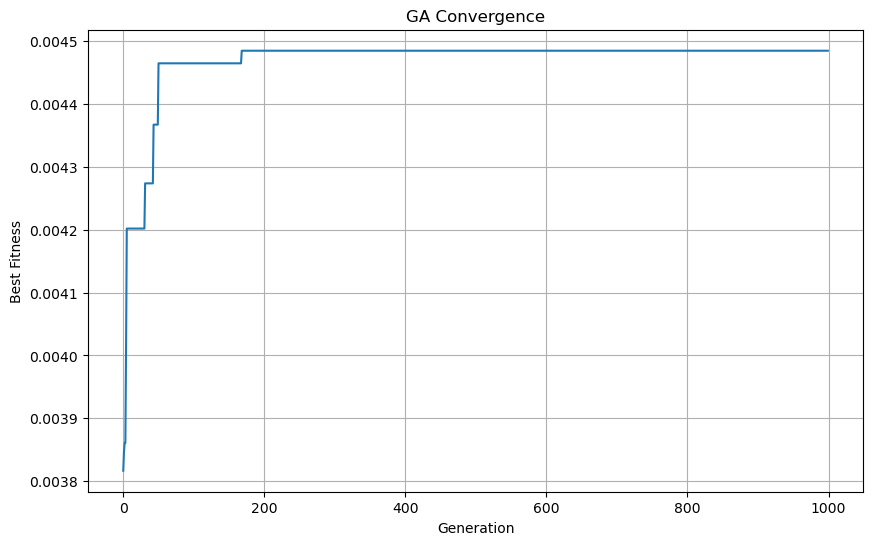

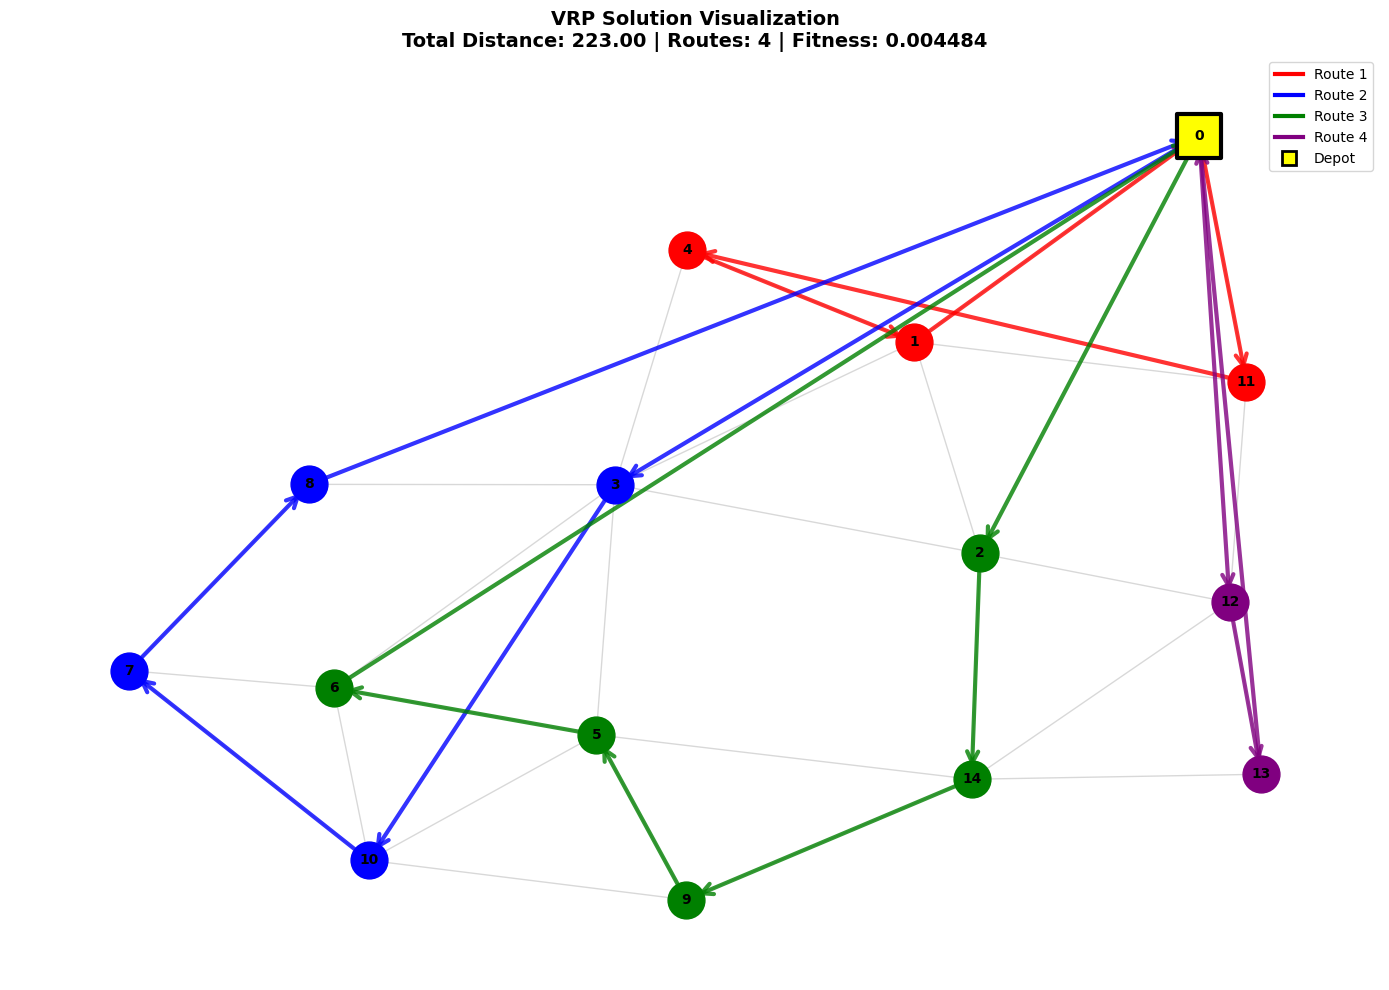


ROUTE DETAILS
Route 1: 0 → 11 → 4 → 1 → 0
  Load: 29/30 | Distance: 33.00
Route 2: 0 → 3 → 10 → 7 → 8 → 0
  Load: 30/30 | Distance: 70.00
Route 3: 0 → 2 → 14 → 9 → 5 → 6 → 0
  Load: 30/30 | Distance: 66.00
Route 4: 0 → 12 → 13 → 0
  Load: 24/30 | Distance: 54.00


In [90]:
best_chrom, best_fit, history = genetic_algorithm(
    pop_size=POPULATION_SIZE,
    elite_count=ELITE_COUNT,
    max_gen=MAX_GENERATION
)

print_solution(best_chrom)
plot_convergence(history)
visualize_routes(best_chrom, G, pos)